In [72]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa

sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
#path_git = git.Repo('.', search_parent_directories=True).working_tree_dir


from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps,solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time


def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
def F_H_prime(H, params, model):
    lamb, L, beta, L_bar = params

    if model == 'GILA':
        aux = np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 + 5 * beta * (L_bar*H)**10) +\
                np.exp(lamb*(L*H)**2) * lamb * (L*H)**6 * (4 + lamb*(L*H)**2)
    if model == 'BETA':
        aux = np.exp(-beta*(L_bar*H)**8)  * beta                * (-1 + 4 * beta * (L_bar*H)**8) +\
            2 * np.exp(lamb*(L*H)**4) * lamb * (L*H)**6 * (2 + lamb*(L*H)**4)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

In [74]:
def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, model] = params_ode

    F_H0 = F_H(H_0, [lamb, L, b, L_bar], model)

    omega_r_0 = 2.47e-5
    omega_m_0 = F_H0 /(100**2) - omega_r_0

    rho_m_0 = 100**2 * omega_m_0 / kappa
    rho_r_0 = 100**2 * omega_r_0 / kappa
    
    #a = 1/(1+z)

    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar],model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0 = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final


def Hubble_th(physical_params, model, *args,
                z_min=0, z_max=10, **kwargs):

    '''
    Calculates the Hubble parameter as a function of redshift for different cosmological models,
    given physical parameters such as the matter density, curvature, and Hubble constant.

    Args:
        physical_params: A tuple of three physical parameters in the order (matter density, curvature, Hubble constant).
        model: A string that specifies the cosmological model to use. Valid options are 'LCDM' (Lambda-CDM),
            'BETA' (beta model) and 'GILA' (GILA model).
        b_crit: A critical value for the distortion parameter use in HS and ST models.
        all_analytic: A boolean flag that specifies whether to use an analytic approximation for the Hubble parameter
            or numerical integration.
        epsilon: A tune parameter that is used to calculate b_crit in the exponential model.
        n: An integer that specifies which of the two possible Taylor series approximations to use for the Hubble
            parameter in the power-law growth models (HS or ST).
        num_z_points: An integer that specifies the number of redshifts at which to compute the Hubble parameter.
        z_min: The minimum redshift value to consider.
        z_max: The maximum redshift value to consider.

    Returns:
        A tuple of two NumPy arrays containing the redshifts and the corresponding Hubble parameters.
    '''
    
    L_bar, b, H0 = physical_params

    zs, Hs = integrator([L_bar, b, H0], model)  
    return zs, Hs   

In [75]:
discard=0
thin=1
root_dic = '/home/matias/Documents/Repos/GILA-output/paper/'

# Get the samples:
samples_lcdm = emcee.backends.HDFBackend(root_dic + 'sample_LCDM_PPS_CC_3params/sample_LCDM_PPS_CC_3params.h5')
samples_beta = emcee.backends.HDFBackend(root_dic + 'sample_BETA_PPS_CC_4params/sample_BETA_PPS_CC_4params.h5')
samples_gila = emcee.backends.HDFBackend(root_dic + 'sample_GILA_PPS_CC_4params/sample_GILA_PPS_CC_4params.h5')

#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)


names_LCDM = ['M_{{abs}}','H_0','\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_LCDM = names_LCDM
names_GILA = ['M_{{abs}}','\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']
labels_GILA = names_GILA

names_GILA_1 = ['\\beta','H_0','\omega_m','\Omega_{{m}}^{{GILA-\\beta}}']
names_GILA_2 = ['\omega_m','\Omega_{{m}}^{{LCDM}}','\Omega_{{\\Lambda}}^{{LCDM}}']

In [76]:
omega_r = 2.47e-5 
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second
zs_final = np.logspace(np.log10(0.001),13,int(10e3))



In [64]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
H0 = flat_samples_lcdm[:,1]
omega_m = flat_samples_lcdm[:,2]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
aou_lcdm = np.zeros(len(H0))

def aou_lcdm_calc(z, H0, Omega_r_lcdm, Omega_m_lcdm, Omega_L_lcdm):
    Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
    return inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z) 

for i in range(len(aou_lcdm)):
    aou_lcdm[i] = aou_lcdm_calc(zs_final, H0[i], Omega_r_lcdm[i], Omega_m_lcdm[i], Omega_L_lcdm[i])

In [81]:
#BETA MODEL
#M_abs = flat_samples_beta[:,0]
beta = flat_samples_beta[:,1]
H0 = flat_samples_beta[:,2]
#omega_m = flat_samples_beta[:,3]
aou_beta = np.zeros(100)

for i in range(len(aou_beta)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    zs_final, Hs_final = integrator_GILA(physical_params,model='BETA', num_z_points=int(10e3),
                                        initial_z=0, final_z=int(10e13))
    aou_beta[i] = inv_Hub_to_Gyr * simps(((1+zs_final) * Hs_final)**(-1), zs_final)    

In [84]:
#GILA MODEL
#M_abs = flat_samples_gila[:,0]
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]
#omega_m = flat_samples_gila[:,3]
aou_gila = np.zeros(100)

for i in range(len(aou_gila)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    zs_final, Hs_final = integrator_GILA(physical_params,model='GILA', num_z_points=int(10e3),
                                        initial_z=0, final_z=int(10e13))
    aou_gila[i] = inv_Hub_to_Gyr * simps(((1+zs_final) * Hs_final)**(-1), zs_final)  

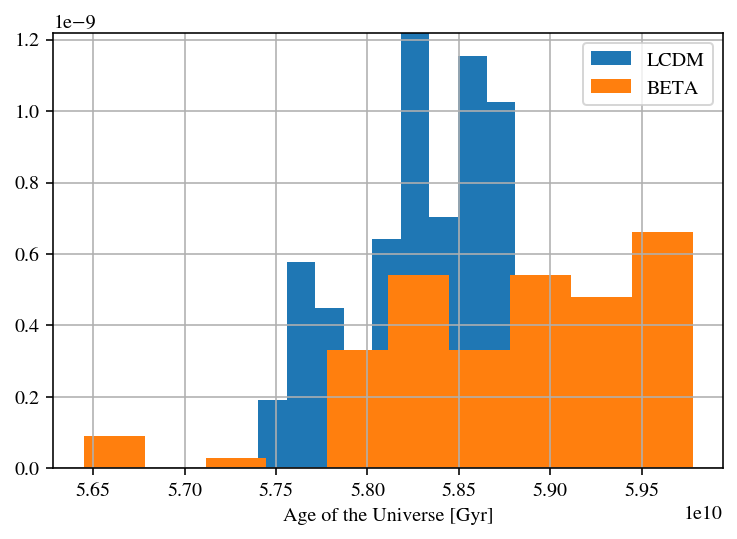

In [86]:
plt.figure()
plt.grid()
#plt.hist(aou_lcdm, bins=int(np.sqrt(len(aou_lcdm))), density=True, alpha=1)
plt.hist(aou_beta, bins=int(np.sqrt(len(aou_beta))), density=True, alpha=1)
plt.hist(aou_gila, bins=int(np.sqrt(len(aou_gila))), density=True, alpha=1)
plt.legend(['LCDM','BETA','GILA'])
plt.xlabel('Age of the Universe [Gyr]')
plt.savefig('Age_of_the_Universe.png')

Idea, subir el numero de pasos en BETA  y GILA